In [ ]:
### Code to test how many spike bins surrounding the current bin to select for decoding

In [1]:
import numpy as np
import scipy.io
from pathlib import Path
import pandas as pd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from functions import *

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# Load .mat files
data_path = Path('D:/MATLAB_Analysis/Pre+process/Fncs/Run_tuning/testing_model_helper_fns/whisker_position_decoding_model/github_files/raw_data/E40')
params1 = scipy.io.loadmat(data_path / 'params.mat')
run_speed = scipy.io.loadmat(data_path / 'run_speed.mat')['run_speed']
SpikeTimes = scipy.io.loadmat(data_path / 'SpikeTimes.mat')['SpikeTimes']
trial_times = scipy.io.loadmat(data_path / 'trial_times.mat')
whisker_position = scipy.io.loadmat(data_path / 'whisker_position.mat')['whisker_position']
endT = trial_times['endT'];
startT = trial_times['startT'];
params = params1['params']
recording_endtime = params['recording_endtime'][0,0]
recording_fps = params['recording_fps'][0,0]
features = params['features'][0, 0]  #'features' is a field in actual_params
fps = features['fps'][0, 0]  # 'fps' is a field in features
vid_start_time = features['VidStartTime'][0, 0]  
vid_end_time = features['VidEndTime'][0, 0]
spike_params = params['spike'][0, 0]
exp_no = params['exp_no'][0,0]
Neuron_ID = spike_params['Neuron_ID'][0, 0]
spikeno_thresh_units = spike_params['spikeno_thresh_units'][0, 0]
stpt_amp_units = spike_params['stpt_amp_units'][0, 0]
run_units = spike_params['run_units'][0, 0]
phase_units = spike_params['phase_units'][0, 0]


In [3]:
r2_test = np.zeros([len(np.arange(1,19,2))])
k = 0
bin_res = 0.1
bins = np.arange(0, recording_endtime, bin_res)
 
VidStartTime = np.array([time[0] for time in vid_start_time])
VidEndTime = np.array([time[0] for time in vid_end_time])

startT = trial_times['startT']
endT = trial_times['endT']
BOOL = [np.any((bin_value > startT) & (bin_value < endT)) for bin_value in bins]

from functions import *
speed_binned = get_features_in_timebins(bins, run_speed, fps, VidStartTime, VidEndTime)
spike = np.array([np.histogram(SpikeTimes[n][0], bins)[0] / bin_res for n in range(Neuron_ID.shape[0])])

# select neurons
select_units = np.where(run_units)[0]   
spike_select = spike[select_units, :]
    
for i in range(1,19,2):
    
    nBins = i#5  # has to be an odd number 

    # Decoding Locomotion speed
    X_speed, output_speed, trial_start_idx, trial_end_idx = get_design_matrix(spike_select, speed_binned, BOOL, nBins-1)
    #find_alpha_ridge_regression(X_speed,output_speed)
    testdata_speed,preddata_speed,model_speed = perform_decoding(X_speed, output_speed, 1800)
    r2_speed,_,corr_coeff_speed = get_errors(testdata_speed,preddata_speed)

    # PLor example trial
    t_sec = 10
    ii = np.random.randint(len(output_speed)-t_sec*1/bin_res)
    print(ii)
    stop_idx = int(ii+t_sec*(1/bin_res))
    x = np.arange(0,stop_idx-ii,1)*bin_res
    speed_pred = model_speed.predict(X_speed)

    plt.plot(x, output_speed[ii:stop_idx], label='actual',color = 'black', alpha=.5)
    plt.plot(x, gaussian_filter(speed_pred[ii:stop_idx], sigma = 0), label='predicted')
    plt.xlabel('time (s)')
    plt.ylabel('run speed (cm/s)')
    plt.ylim([0,65])
    plt.title(f" E-{exp_no[0][0]},bin_res={bin_res},nbins={nBins},R2={r2_speed}")
    plt.legend()
    #plt.show()
    np.where(np.round(speed_binned)==11)[0]
    #path = data_path / f'run_trace E-{exp_no[0][0]},bin_res={bin_res},nbins={nBins},R2={r2_speed}.svg'
    #plt.savefig(path, format='svg')
    #plt.close()
    r2_test[k] = r2_speed
    k = k+1
    

R^2: 0.4055929409184176
363
R^2: 0.5969186515810047
2476
R^2: 0.6653661669239437
1283
R^2: 0.7026442066567644
395
R^2: 0.7219205696802546
1104
R^2: 0.7423138964152446
1678
R^2: 0.7524031120382997
862
R^2: 0.758767550098689
554
R^2: 0.7698768242376058
1948


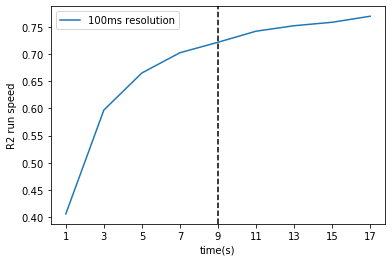

In [4]:
x_steps = np.arange(1,19,2);
plt.plot(x_steps,r2_test, label='100ms resolution')
plt.axvline(9, color='k', linestyle='--')
plt.xlabel('time(s)')
plt.xticks(x_steps)
plt.ylabel('R2 run speed')
plt.legend()
#plt.show()
path = data_path /f'bins_decoding_run.svg'
plt.savefig(path, format='svg')

In [5]:
r2_test_whisker = np.zeros([len(np.arange(1,19,2))])
k = 0
bin_res = 0.015
bins = np.arange(0, recording_endtime, bin_res)
BOOL = [np.any((bin_value > startT) & (bin_value < endT)) for bin_value in bins]

whisker_binned = get_features_in_timebins(bins, whisker_position, fps, VidStartTime, VidEndTime)
spike = np.array([np.histogram(SpikeTimes[n][0], bins)[0] / bin_res for n in range(Neuron_ID.shape[0])])

# select neurons
select_units = np.where(np.logical_or(stpt_amp_units,phase_units))[0]   
spike_select = spike[select_units, :]
    
for i in range(1,19,2):
    
    nBins = i#5  # has to be an odd number 

    # Decoding Locomotion speed
    X_whisker, output_whisker, trial_start_idx, trial_end_idx = get_design_matrix(spike_select, whisker_binned, BOOL, nBins-1)
    #find_alpha_ridge_regression(X,output_whisker)
    testdata_whisker,preddata_whisker,model_whisker = perform_decoding(X_whisker, output_whisker, 2700)
    r2_whisker,_,corr_coeff_whisker = get_errors(testdata_whisker,preddata_whisker)

    # PLor example trial
    t_sec = 10
    ii = np.random.randint(len(output_whisker)-t_sec*1/bin_res)
    #print(ii)
    stop_idx = int(ii+t_sec*(1/bin_res))
    x = np.arange(0,stop_idx-ii,1)*bin_res
    whisk_pred = model_whisker.predict(X_whisker)

    plt.plot(x, output_whisker[ii:stop_idx], label='actual',color = 'black', alpha=.5)
    plt.plot(x, gaussian_filter(whisk_pred[ii:stop_idx], sigma = 0), label='predicted')
    plt.xlabel('time (s)')
    plt.ylabel('whisker angle ($^0$)')
    #plt.ylim([0,65])
    plt.title(f" E-{exp_no[0][0]},bin_res={bin_res},nbins={nBins},R2={r2_speed}")
    plt.legend()
    #plt.show()
    #path = data_path / f'whisker_trace E-{exp_no[0][0]},bin_res={bin_res},nbins={nBins},R2={r2_speed}.svg'
    #plt.savefig(path, format='svg')
    #plt.close()
    r2_test_whisker[k] = r2_whisker
    k = k+1
    

R^2: 0.36011278810971137
10642
R^2: 0.576657704053441
14075
R^2: 0.6486386585435074
6828
R^2: 0.6895815682308133
5238
R^2: 0.7187985461571653
4329
R^2: 0.7353433915753085
6668
R^2: 0.7496438703590379
3637
R^2: 0.7583837815941155
17906
R^2: 0.7658694507178687
6587


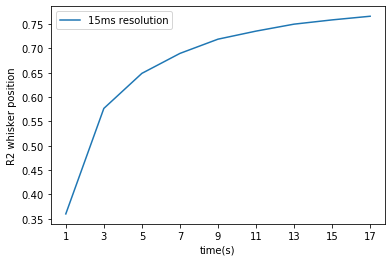

In [6]:
x_steps = np.arange(1,19,2);
plt.plot(x_steps,r2_test_whisker, label='15ms resolution')
#plt.axvline(9, color='k', linestyle='--')
plt.xlabel('time(s)')
plt.xticks(x_steps)
plt.ylabel('R2 whisker position')
plt.legend()
#plt.show()
path = data_path /f'bins_decoding_whisk.svg'
plt.savefig(path, format='svg')